In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import os
import matplotlib.ticker as ticker

# Make figures have reasonable quality
matplotlib.rcParams['figure.dpi'] = 150 

# Read the CSV file
data_csv = pd.read_csv('TWO_CENTURIES_OF_UM_RACES.csv')

# Check the data was loaded
print("Rows: ", data_csv.shape[0], " Columns: " ,data_csv.shape[1])

# Define colors for the bars
base_colours = ['#ff7f0e','#1f77b4']


C:\Users\Admin\AppData\Local\Temp\ipykernel_13988\2978136181.py:13: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv('TWO_CENTURIES_OF_UM_RACES.csv')


Rows:  7461195  Columns:  13


In [2]:
# Drop rows with missing data
data = data_csv.dropna()

# Rename the columns
data = data.rename(columns={'Event distance/length': 'distance'})

In [3]:
# Remove the rows that distances' values have the following strings
remove = ['h', 'Etappen', 'le', 'd',',','stages', '\+', 'NaN', 'NA', 'test', 'Split', 'x', 'Etap']
data = data[~data['distance'].str.contains('|'.join(remove))]

In [4]:
def miles_to_km(distance):
    return int(round(float(distance.replace('mi', '')) * 1.609344, 0))

def convert_distance_to_km(distance):
    if 'mi' in distance:
        return miles_to_km(distance)
    elif 'km' in distance:
        return int(round(float(distance.replace('km', '').strip()), 0))
    else:
        return 

# Convert distances to kilometers
data['distance'] = [convert_distance_to_km(dist) for dist in data['distance']]

# remove nan values in distance
data = data.dropna(subset=['distance'])

# change data type of distance to int array
data['distance'] = data['distance'].astype(int)


In [5]:
def convert_speed_to_float(speed):
    try: 
        if (float(speed) > 1000):
            return speed / 1000
        else:
            return speed
    except:
        return np.nan

# round the average speed to 2 decimal places
data['Athlete average speed'] = [convert_speed_to_float(speed) for speed in data['Athlete average speed']]

# remove nan values in Athlete average speed
data = data.dropna(subset=['Athlete average speed'])

# change data type of Athlete average speed to float array
data['Athlete average speed'] = data['Athlete average speed'].astype(float)

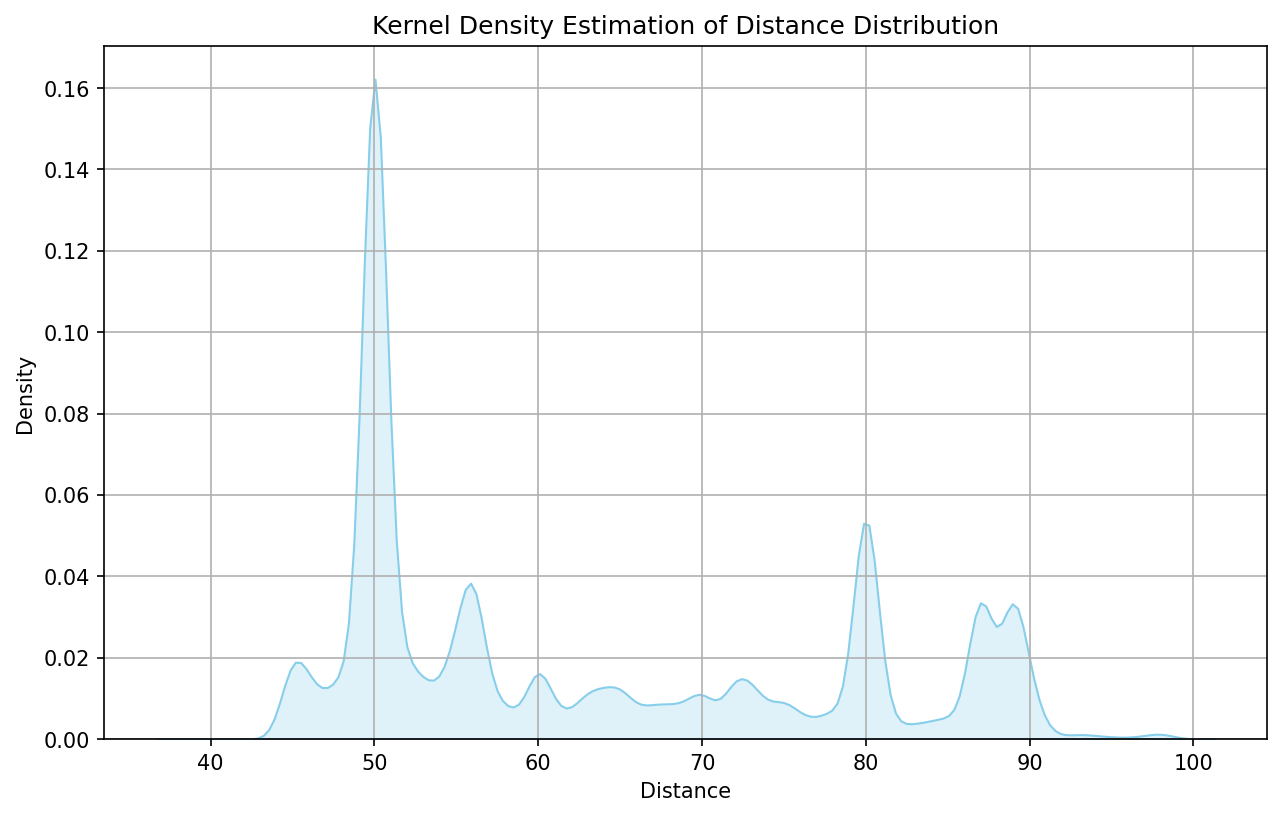

In [6]:
### Plot the Race Distance Distribution

# Filter out the distances that are greater than 100 km
filtered_data = data[data['distance'] < 100]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['distance'], color='skyblue', fill=True)
plt.xlabel('Distance')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Distance Distribution')
plt.grid(True)
plt.show()


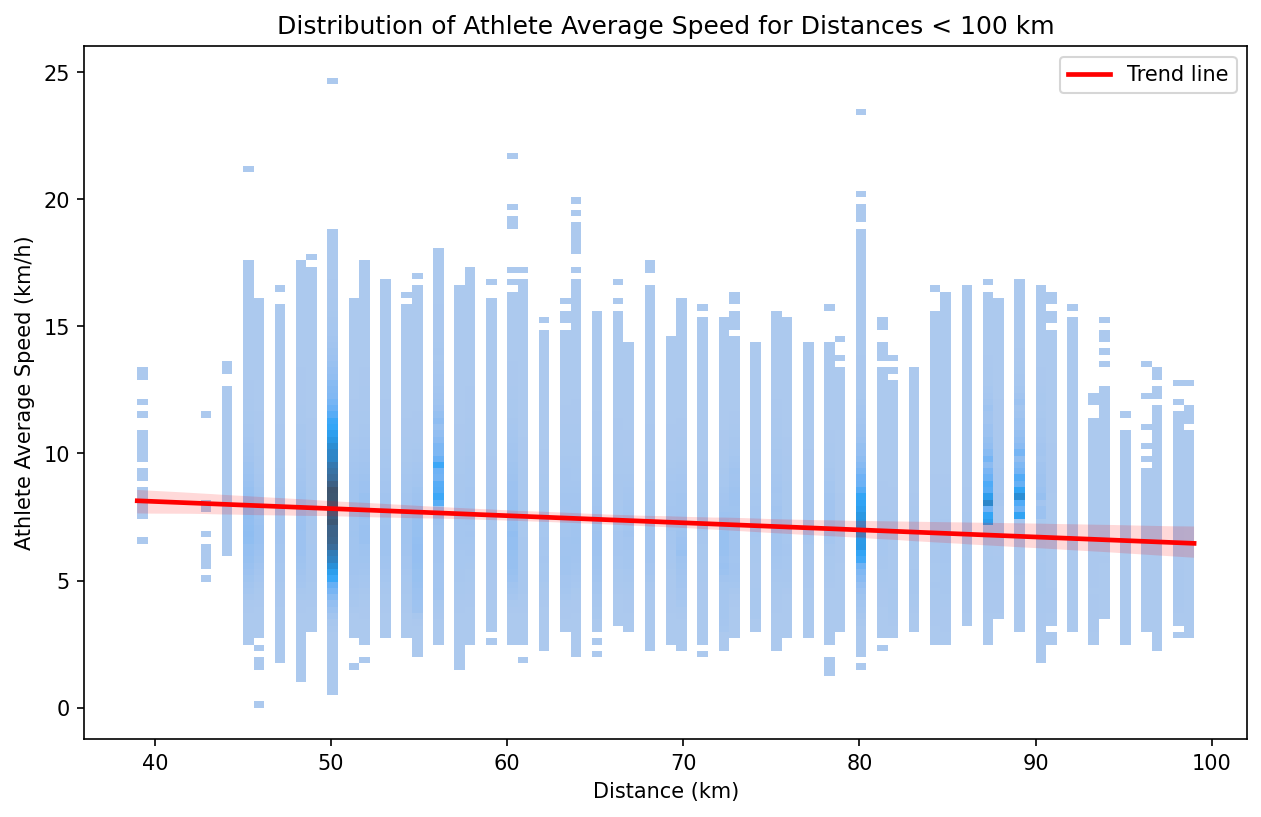

In [7]:
### Plot the Athlete Average Speed Distribution over distances less than 100 km

# Filter for distances less than 100 km
filtered_data = data[data['distance'] < 100]

# Filter for average speeds less than 40 km/h
filtered_data = filtered_data[filtered_data['Athlete average speed'] < 40]

# Calculate average speed for each distance bin
average_speeds = filtered_data.groupby('distance')['Athlete average speed'].mean().reset_index()

# Plot histogram of athlete average speed for distances less than 100 km
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_data, x='distance', y='Athlete average speed', bins=100, kde=True)

# Add trend line
sns.regplot(data=average_speeds, x='distance', y='Athlete average speed', scatter=False, color='red', label='Trend line')

plt.title('Distribution of Athlete Average Speed for Distances < 100 km')
plt.xlabel('Distance (km)')
plt.ylabel('Athlete Average Speed (km/h)')
plt.legend()
plt.show()


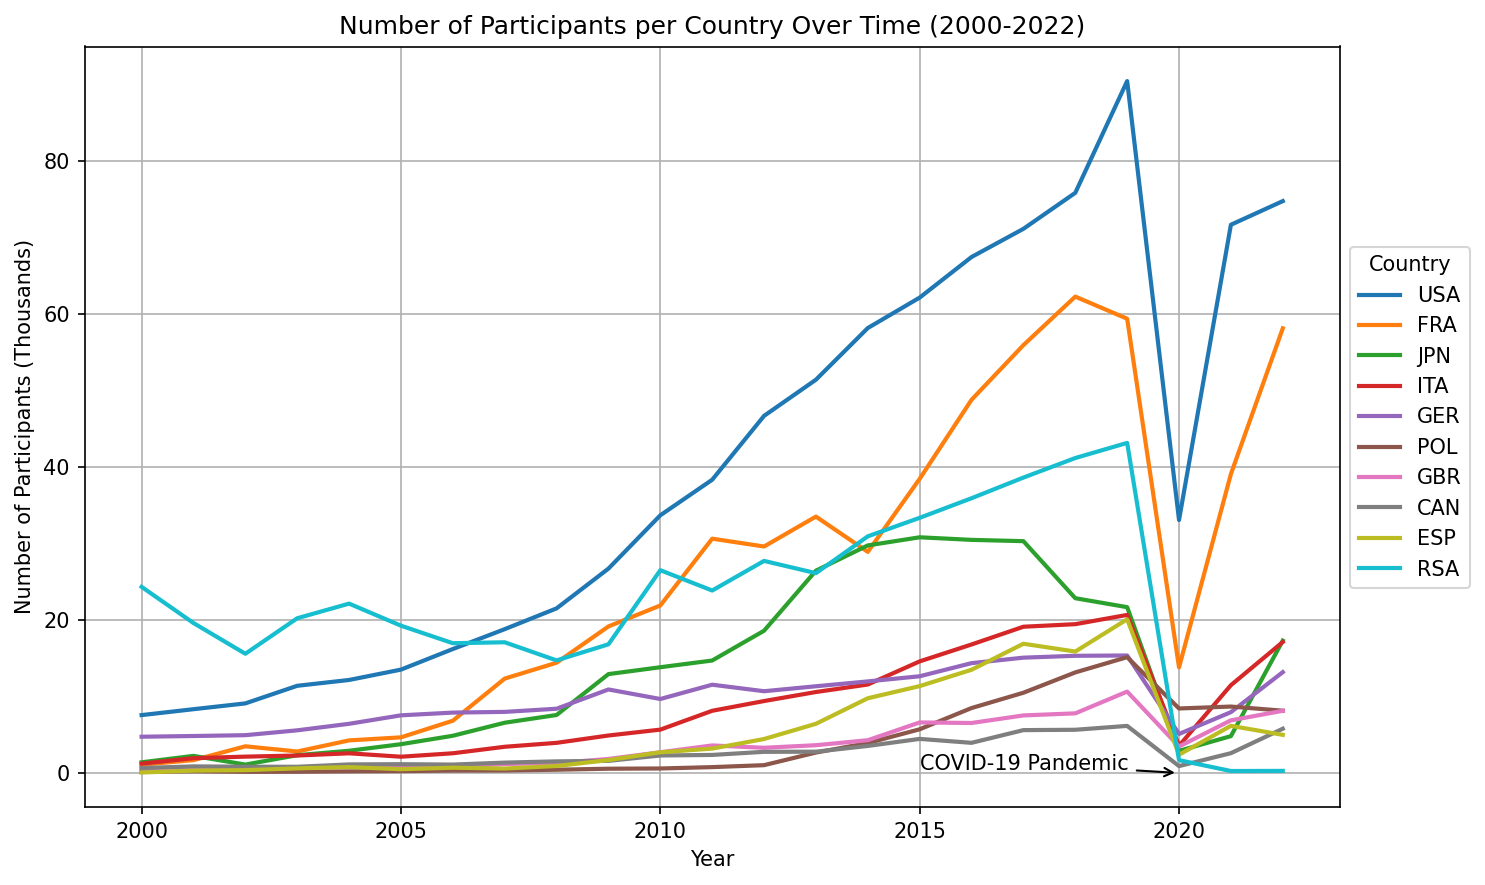

In [8]:

### Plot Number of Participants per Country Over Time

# filter data for 2000 to 2022
filtered_data = data[(data['Year of event'] >= 2000) & (data['Year of event'] <= 2022)]

# group by country
participants_per_country = filtered_data.groupby(['Athlete country']).size().reset_index(name='Number of Participants')

# get the top 10 countries with the most participants
top_10_countries = participants_per_country.nlargest(10, 'Number of Participants')

# Create a set of distinct colors for each country
colors = sns.color_palette('tab10', n_colors=10)

# Filter for the top 10 countries
filtered_data = filtered_data[filtered_data['Athlete country'].isin(top_10_countries['Athlete country'])]

# Calculate number of participants per country
participants_per_country = filtered_data.groupby(['Year of event', 'Athlete country'])['Athlete country'].count().unstack()

# Divide values by 1000 for better readability
participants_per_country = participants_per_country / 1000

# get the order of the top 10 countries participation in 2022
top_10_countries_2022 = participants_per_country.loc[2022].sort_values(ascending=False).index

# sort the columns by the order of the top 10 countries participation in 2022
participants_per_country = participants_per_country[top_10_countries_2022]

# Plot number of participants per country over time
plt.figure(figsize=(10, 6))
participants_per_country.plot(kind='line', ax=plt.gca(), linewidth=2, alpha=1, color = colors)
plt.title('Number of Participants per Country Over Time (2000-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Participants (Thousands)')
plt.legend(title='Country', bbox_to_anchor=(1, 0.75))
plt.grid(True)
plt.tight_layout()

# Annotate the COVID-19 pandemic
plt.annotate('COVID-19 Pandemic', xy=(2020, 0), xytext=(2015, 0.4),
             arrowprops=dict(facecolor='black', arrowstyle='->'))


plt.show()



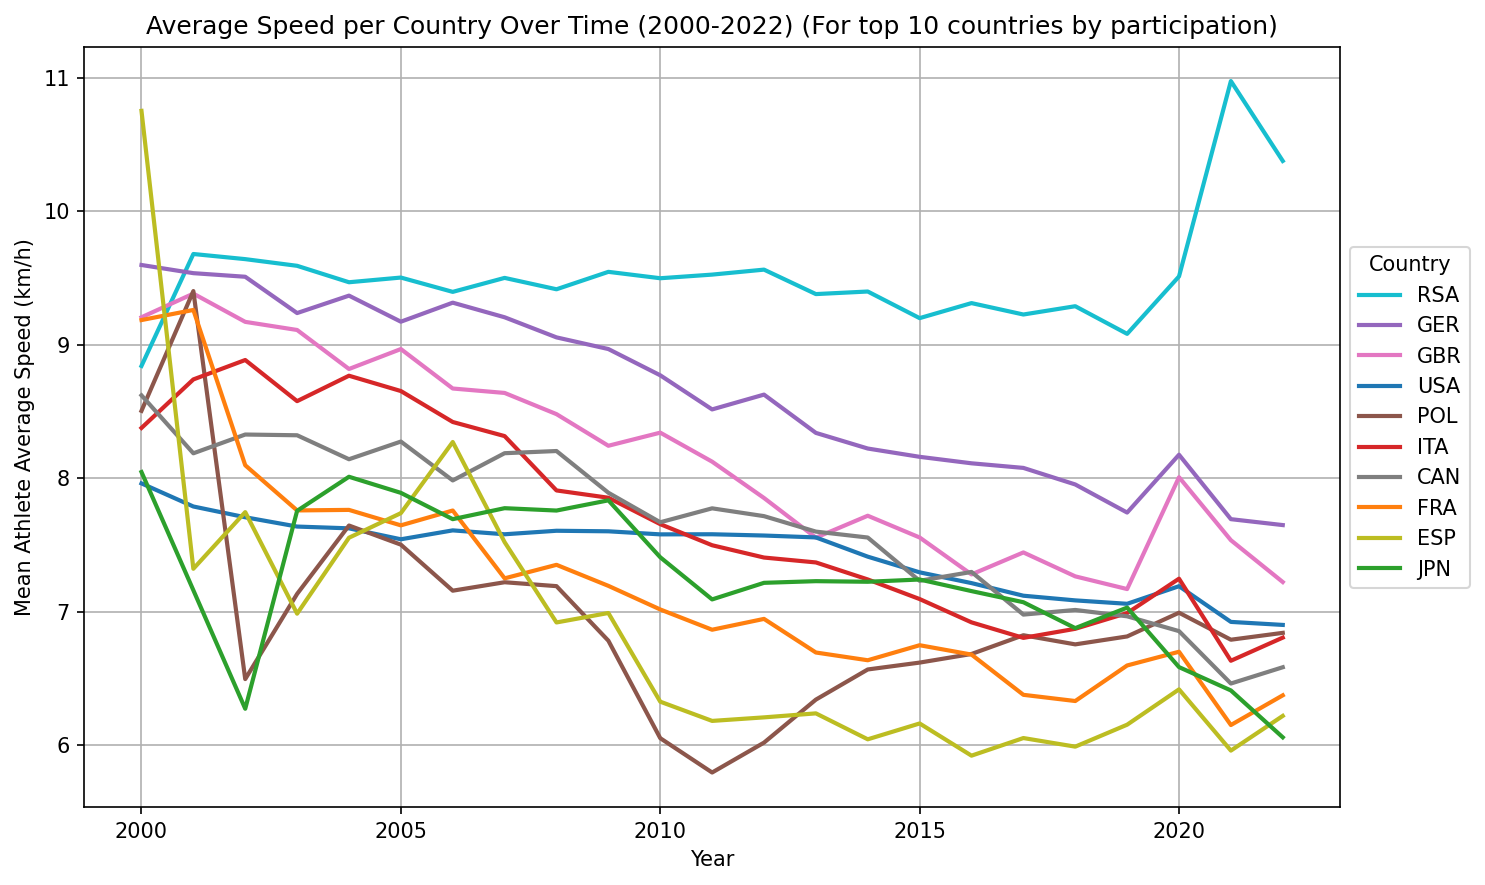

In [9]:

### Plot Average Speed per Country Over Time

# Calculate average speed per country
average_speed_per_country = filtered_data.groupby(['Year of event', 'Athlete country'])['Athlete average speed'].mean().unstack()

# get the order of the top 10 countries average speed in 2022
top_10_countries_2022_speed = average_speed_per_country.loc[2022].sort_values(ascending=False).index

# sort the columns by the order of the top 10 countries average speed in 2022
average_speed_per_country = average_speed_per_country[top_10_countries_2022_speed]

# sort the colours appropriately from the previous graph
new_colors = [];
for country in average_speed_per_country.columns:
    # get the position of the country in the top 10 countries participation in 2022
    position = np.where(top_10_countries_2022 == country)[0][0]
    # get the color of the country
    color = colors[position]
    new_colors.append(color)


# Plot average speed per country over time
plt.figure(figsize=(10, 6))
average_speed_per_country.plot(kind='line', ax=plt.gca(), linewidth=2, alpha=1, color = new_colors)
plt.title('Average Speed per Country Over Time (2000-2022) (For top 10 countries by participation)')
plt.xlabel('Year')
plt.ylabel('Mean Athlete Average Speed (km/h)')
plt.legend(title='Country', bbox_to_anchor=(1, 0.75))
plt.grid(True)
plt.tight_layout()
plt.show()

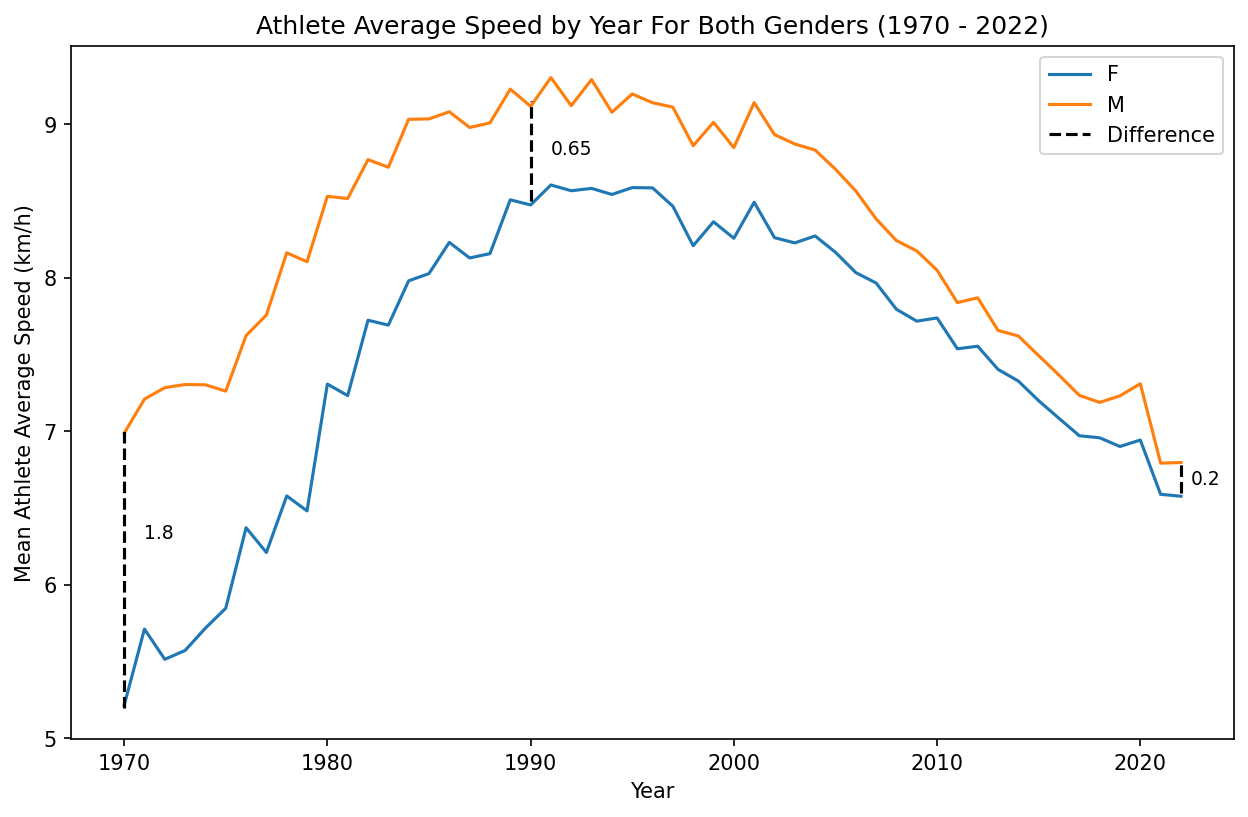

In [10]:

### Plot Athlete Average Speed by Year For Both Genders


# Group the data by year and gender, and calculate the mean of 'Athlete average speed'
average_speeds_year_gender = data.groupby(['Year of event', 'Athlete gender'])['Athlete average speed'].mean().reset_index()

# Filter the data for the years 1970 and later
average_speeds_year_gender = average_speeds_year_gender[average_speeds_year_gender['Year of event'] >= 1970]

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_speeds_year_gender, x='Year of event', y='Athlete average speed', hue='Athlete gender')
plt.title("Athlete Average Speed by Year For Both Genders (1970 - 2022)")
plt.xlabel("Year")
plt.ylabel("Mean Athlete Average Speed (km/h)")

# Add difference annotations
plt.vlines(x = 1970, ymin=5.2, ymax=7, color='black', linestyle='--', label='Difference')
plt.text(1971, 6.3, '1.8', fontsize=9, color='black')

plt.vlines(x = 2022, ymin=6.6, ymax=6.8, color='black', linestyle='--')
plt.text(2022.5, 6.65, '0.2', fontsize=9, color='black')

plt.vlines(x = 1990, ymin=8.5, ymax=9.15, color='black', linestyle='--')
plt.text(1991, 8.8, '0.65', fontsize=9, color='black')

plt.legend()
plt.show()


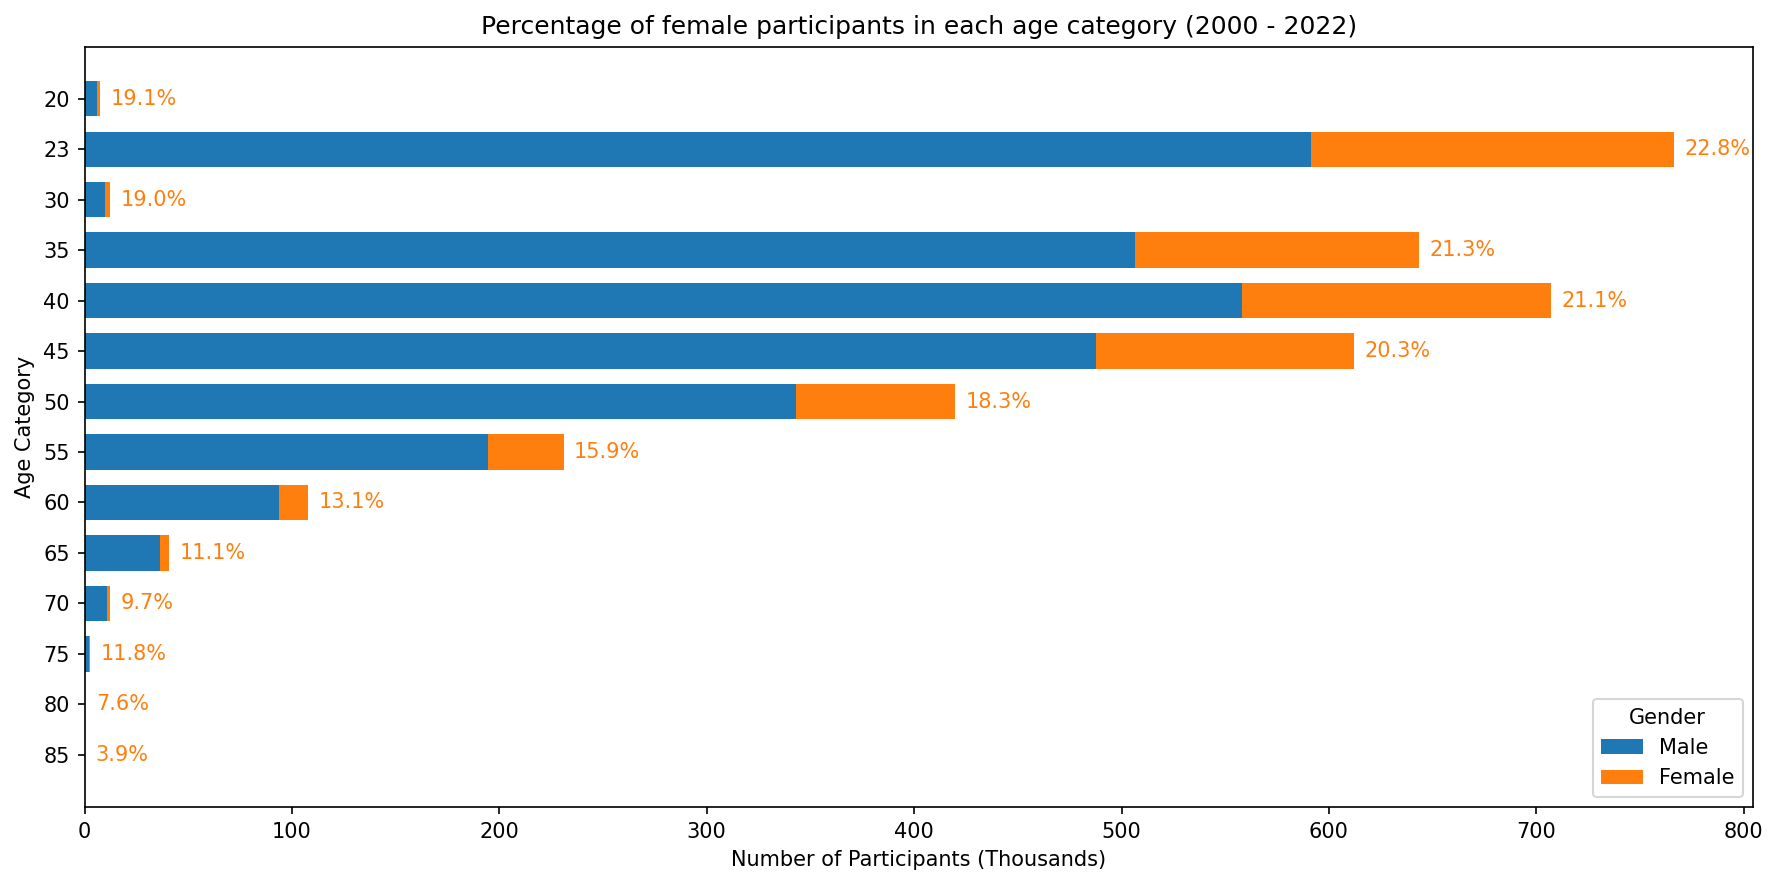

In [11]:
### Plot Percentage of female participants in each age category (2000 - 2022)

# Filter for data after 2000
filtered_data = data[data['Year of event'] >= 2000]

## Extract the overlapping age categories
age_categories = filtered_data['Athlete age category'].unique() 
male_categories = [cat for cat in age_categories if cat.startswith('M')]
female_categories = [cat for cat in age_categories if cat.startswith('W')]
# Extract the numbers from the age categories
nums_list1 = [int(x[1:]) for x in male_categories if x[1:].isdigit()]
nums_list2 = [int(x[1:]) for x in female_categories if x[1:].isdigit()]
# Find the common age categories
common_numbers = set(nums_list1).intersection(nums_list2)
common_numbers = sorted(list(common_numbers))
# Create litst containing the common age categories
male_categories = ['M' + str(num) for num in common_numbers]
female_categories = ['W' + str(num) for num in common_numbers]

# Group the data by 'Athlete age category' and count the number of participants
age_counts = filtered_data.groupby('Athlete age category').size().sort_values(ascending=False)

# divide age_counts by 1000 for better readability
age_counts = age_counts / 1000

# Filter the data for the categories that intersect
male_participants = [age_counts[cat] for cat in male_categories]
female_participants = [age_counts[cat] for cat in female_categories]

# Width of the bars
width = 0.7

# Create an array of x labels
x = np.arange(len(common_numbers))

# Plot
plt.figure(figsize=(12, 6))
plt.ylabel('Age Category')
plt.xlabel('Number of Participants (Thousands)')
plt.title('Percentage of female participants in each age category (2000 - 2022)')
plt.yticks(ticks=x, labels=common_numbers)
plt.tight_layout()

# Plot the bars
plt.barh(x, male_participants, width, label='Male', color=base_colours[1])
plt.barh(x, female_participants, width, left=male_participants, label='Female', color=base_colours[0])

# Calculate the total number of participants
total_participants = [m + f for m, f in zip(male_participants, female_participants)]

# Add percentage labels
for i in range(len(x)):
    female_percentage = female_participants[i] / total_participants[i] * 100
    plt.text(male_participants[i] + female_participants[i] + 5, x[i], f'{female_percentage:.1f}%', ha='left', va='center', color=base_colours[0], label = 'Test')

# Add legend
plt.legend(title= 'Gender', loc = 'lower right')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()



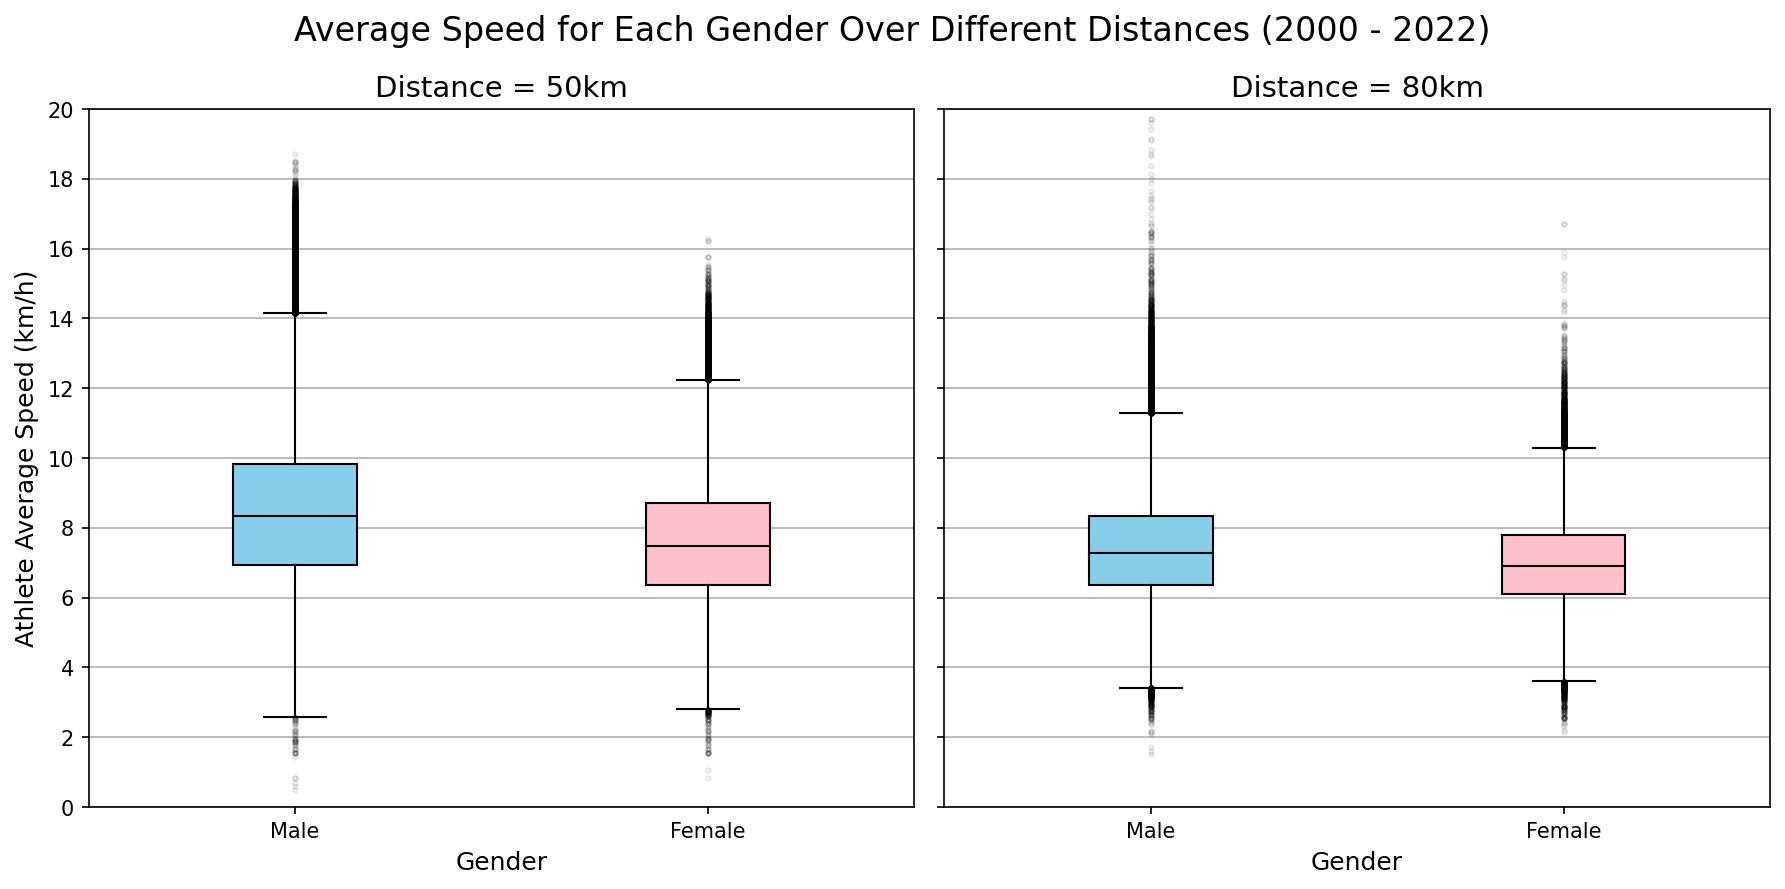

In [12]:

### Plot Box Plots of Average Speed for Each Gender Over Different Distances

data_50k = data[data['distance'] == 50]
data_80k = data[data['distance'] == 80]

data_50k = data_50k[data_50k['Year of event'] >= 2000]
data_80k = data_80k[data_80k['Year of event'] >= 2000]

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Add an overall title for the figure
fig.suptitle('Average Speed for Each Gender Over Different Distances (2000 - 2022)', fontsize=16)

# Plot box plots for the first distance on the first subplot
boxprops1 = dict(facecolor="skyblue")
boxprops2 = dict(facecolor="pink")
bplot1 = ax1.boxplot([data_50k['Athlete average speed'][data_50k['Athlete gender'] == 'M'],
                      data_50k['Athlete average speed'][data_50k['Athlete gender'] == 'F']],
                     labels=['Male', 'Female'], patch_artist=True, boxprops=boxprops1, widths = 0.3)

ax1.set_title('Distance = 50km', fontsize=14)
ax1.set_xlabel('Gender', fontsize=12)
ax1.set_ylabel('Athlete Average Speed (km/h)', fontsize=12)
ax1.set_ylim([0, 20])
ax1.set_yticks(np.arange(0, 22, 2))
ax1.yaxis.grid(True)

# Customize average lines to be black
for line in bplot1['medians']:
    line.set_color('black')

# Customize box colors
colors = ['skyblue', 'pink']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# Customize outlying points
for flier in bplot1['fliers']:
    flier.set(marker='o', color='black', alpha=0.1, markersize=2)  # Adjust marker shape, color, and size


# Plot box plots for the second distance on the second subplot
boxprops1 = dict(facecolor="lightgreen")
boxprops2 = dict(facecolor="lightcoral")
bplot2 = ax2.boxplot([data_80k['Athlete average speed'][data_80k['Athlete gender'] == 'M'],
                      data_80k['Athlete average speed'][data_80k['Athlete gender'] == 'F']],
                     labels=['Male', 'Female'], patch_artist=True, boxprops=boxprops1, widths = 0.3)

ax2.set_title('Distance = 80km', fontsize=14)
ax2.set_xlabel('Gender', fontsize=12)
ax2.set_ylim([0, 20])
ax2.set_yticks(np.arange(0, 22, 2))
ax2.set_yticklabels([])
ax2.yaxis.grid(True)

# Customize average lines to be black
for line in bplot2['medians']:
    line.set_color('black')

# Customize box colors
colors = ['skyblue', 'pink']
for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

# Customize outlying points
for flier in bplot2['fliers']:
    flier.set(marker='o', color='black', alpha=0.1, markersize=2)  # Adjust marker shape, color, and size


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [13]:
### Extract the month of the event from the 'Event dates' column

def get_month(date):
    if '-' in date:
        return date.split('-')[1].split('.')[1]
    else:
        return date.split('.')[1]

# apply the function to the column
data['Month'] = data['Event dates'].apply(get_month)

# Create a dictionary that maps month numbers to names
month_dict = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May', '06': 'Jun', 
              '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

# Replace the month numbers with their names in the 'Month' column
data['Month'] = data['Month'].map(month_dict)

# Check to see all monts are converted to names
print(data['Month'].unique())

['Jan' 'Mar' 'Feb' 'May' 'Apr' 'Jun' 'Aug' 'Jul' 'Sep' 'Oct' 'Dec' 'Nov'
 nan]


In [14]:
## Import global temperature data

# Read the global temperatures CSV file into a DataFrame
df = pd.read_csv('monthly-temps.csv')


def handle_temp_data(df): 
    
    # create an array of all the years from 2000 to 2022
    years = np.arange(2000, 2023)

    years_temps = []

    for year in years:
        # Filter the data for the current year
        temp_data = df[str(year)]
        average_temp = []
        interval = 12
        length = round(len(temp_data) / interval)

        for i in range(0, interval):
            sum = 0
            for j in range(0, length):
                temp = temp_data[j * interval + i]
                sum += temp
            average_temp.append(sum / length / 2.2)

        years_temps.append(average_temp)

    years_average_temps = []

    for x in range (0, 12):
        sum = 0
        for y in range(0, len(years_temps)):
            sum += years_temps[y][x]
        years_average_temps.append(sum / len(years_temps))

    return years_average_temps

years_average_temps = handle_temp_data(df)

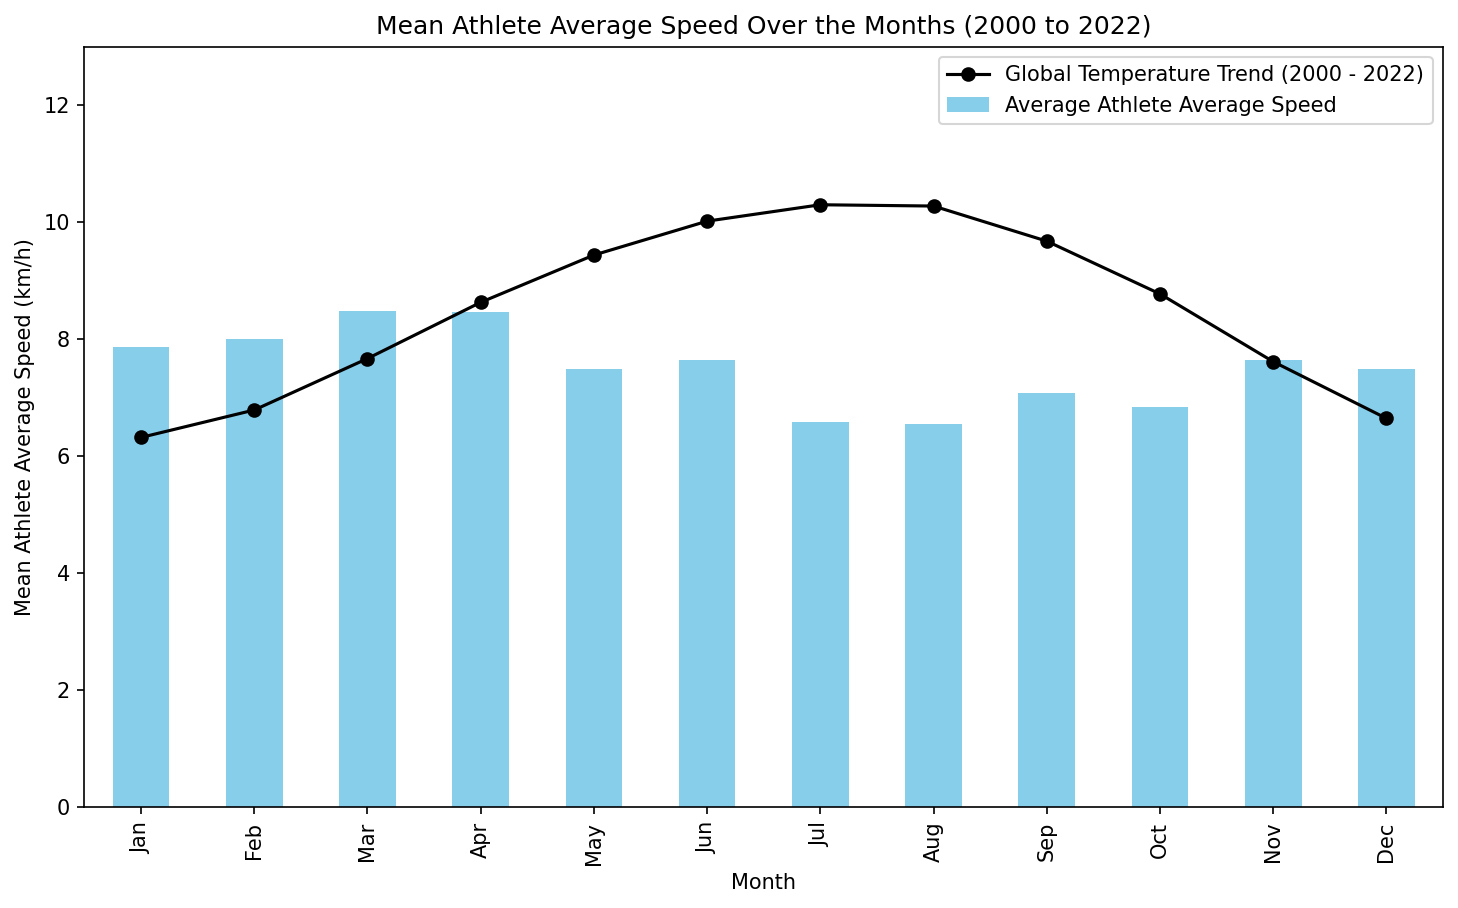

In [15]:

### Plot Average Athlete Speed Over the Months (2000 to 2022) along with Global Temperature Trend

# Filter the data for the years 2000 and later
filtered_data = data[data['Year of event'] >= 2000]

# Calculate average speed per month
average_speed_per_month = filtered_data.groupby('Month')['Athlete average speed'].mean().reindex(month_dict.values())

# Plot the data
plt.figure(figsize=(10, 6))
ax = plt.gca()  
plt.title('Mean Athlete Average Speed Over the Months (2000 to 2022)')
plt.xlabel('Month')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.ylabel('Mean Athlete Average Speed (km/h)')
plt.grid(True)
plt.tight_layout()

# Plot average speed per month
average_speed_per_month.plot(kind='bar', color='skyblue', ax=ax, label = 'Average Athlete Average Speed')  # Plot bar graph

# Plot the global temperature trend
ax.plot(years_average_temps, marker='o', color='black', linestyle='-', label='Global Temperature Trend (2000 - 2022)')  # Plot line graph on the same axes

# add margin to top of the plot
plt.ylim(0, 13)

# Add legend
plt.legend()  

plt.show()

In [16]:
### Train a linear regression model to predict athlete average speed

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pandas as pd
import random

# Filter the data for distance = 50 km
data = data[data['distance'] == 50]

# Load the data
# Assuming you have a pandas DataFrame called 'data'
# Select features and target
features = ['Athlete year of birth', 'Athlete country', 'Athlete gender', 'Year of event', 'Month']
target = 'Athlete average speed'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Define a ColumnTransformer to handle categorical variables
categorical_features = ['Athlete country', 'Athlete gender']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Select 5 random samples from the data
random_samples = data.sample(n=5, random_state=42)

# Make predictions on the random samples
predictions = pipeline.predict(random_samples[features])

# Print the predictions against the actual values
for i, prediction in enumerate(predictions):
    print(f'Predicted: {prediction:.2f} km/h, Actual: {random_samples.iloc[i]["Athlete average speed"]:.2f} km/h')


Mean Squared Error: 3.4032437067073613
Predicted: 8.23 km/h, Actual: 10.47 km/h
Predicted: 9.18 km/h, Actual: 10.27 km/h
Predicted: 8.04 km/h, Actual: 7.79 km/h
Predicted: 8.78 km/h, Actual: 6.09 km/h
Predicted: 9.32 km/h, Actual: 9.11 km/h


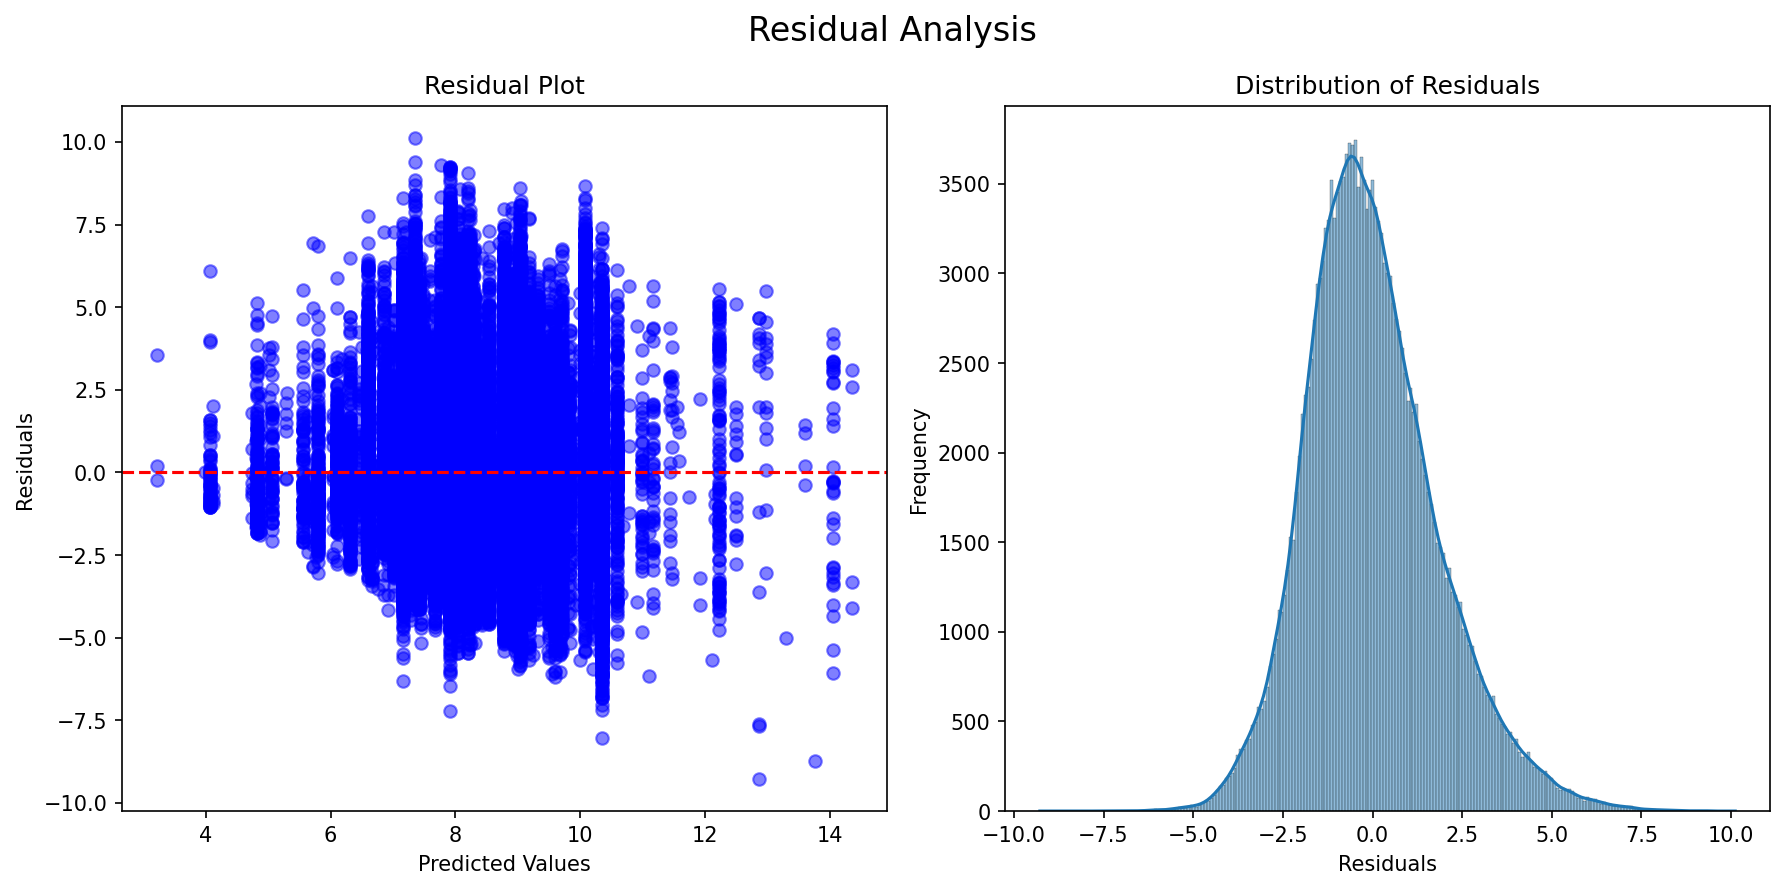

In [17]:

# Calculate Residuals
residuals = y_test - y_pred

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# add super title
fig.suptitle('Residual Analysis', fontsize=16)

# Residual Plot
ax1.scatter(y_pred, residuals, c='blue', marker='o', alpha=0.5)
ax1.set_title('Residual Plot')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals')
ax1.axhline(y=0, color='red', linestyle='--')

# Distribution Plot of Residuals
sns.histplot(residuals, kde=True, ax=ax2)
ax2.set_title('Distribution of Residuals')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
